Welcome to Day 4 of the 5-Day Data Challenge! Today, we're going to be looking at **deduplication**.

"Duplication" just means that you have repeated data in your dataset. This could be due to things like data entry errors or data collection methods. For example, if you're using a web scraper you may happen to scrape the same webpage more than once, or the same information from two different pages. 
Whatever the reason, duplication can lead you to make incorrect conclusions by leading you to believe that some observations are more common than they really are.

Today we're going to learn how to find and remove duplicate records. (Removing duplicates is called "deduplication".) Here's a quick overview of what we'll be doing today.

* Visualizing duplication 
* Finding & removing exact duplicates
* Finding & removing partial duplicates

I'll start by introducing each concept or technique, and then you'll get a chance to apply it with an exercise (look for the **Your turn!** section). Ready? Let's get started!

___

**Kernel FAQs:**

* **How do I get started?**   To get started, click the blue "Fork Notebook" button in the upper, right hand corner. This will create a private copy of this notebook that you can edit and play with. Once you're finished with the exercises, you can choose to make your notebook public to share with others. :)

* **How do I run the code in this notebook?** Once you fork the notebook, it will open in the notebook editor. From there you can write code in any code cell (the ones with the grey background) and run the code by either 1) clicking in the code cell and then hitting CTRL + ENTER or 2) clicking in the code cell and the clicking on the white "play" arrow to the left of the cell. If you want to run all the code in your notebook, you can use the double, "fast forward" arrows at the bottom of the notebook editor.

* **How do I save my work?** Any changes you make are saved automatically as you work. You can run all the code in your notebook and save a static version by hitting the blue "Commit & Run" button in the upper right hand corner of the editor. 

* **How can I find my notebook again later?** The easiest way is to go to your user profile (https://www.kaggle.com/replace-this-with-your-username), then click on the "Kernels" tab. All of your kernels will be under the "Your Work" tab, and all the kernels you've upvoted will be under the "Favorites" tab.

___


# Get our environment set up
___

Before we get started, we need to get our environment set up. Today, we'll be working with two video game datasets. The `video_game` dataset contains information on what games some Steam users bought and how many hours they spent playing them. The `ign_data` dataset contains information on reviews of different video games.

In [1]:
# libraries we'll need
library(tidyverse) # handy utility functions
library(scrubr) # for deduplication

# read in Steam video game data & add column names
video_games <- read.csv("../input/steam-video-games/steam-200k.csv", header = F) # read in data
names(video_games) <- c("user_id", "game_title", "behavior_name", "value", "x") # add column names
video_games <- as_data_frame(video_games[, 1:4]) # drop last column & convert to data_frame

# read in IGN video game data
ign_data <- read_csv("../input/20-years-of-games/ign.csv")
ign_data <- select(ign_data, -X1) # drop column with row numbers

# What is duplication?
___

To start off, let's define what we mean by "duplication". Duplication can mean two slightly different things: 

1.  More than one record that is exactly the same. This is what I call "exact duplication".
2. More than one record associated with the same observation, but the values in the rows are not exactly the same. This is what I call "partial duplication", but removing these types of duplicated records is also called "record linkage". 

Today, we'll be talking about methods to identify and remove both of these types of duplication. 

# Visualizing duplication 
____

You may have noticed that I tend to do a lot of visualizing as part of different data cleaning tasks, and deduplication is no exception! Let's take a look at how many rows are duplicated in our dataset and where they are. There are a couple reasons you may want to do this:

1. See how much duplicated data you have. If you only have a couple duplicates, or even none, you can just move on without worrying about them.
2. See if there are any patterns in duplication. One fairly common pattern is that you'll see big blocks of duplicates due to data being copy and pasted at the end of existing data. If that's the case, you can just remove those rows from your dataframe and call it a day.

To plot duplicates, I'm first going to create a dataframe with 1) a logical vector indicating whether or not a specific row is duplicated elsewhere in the dataset and 2) a numeric vector of the index of each row. (I'm not using row numbers because if you're using the Tidyverse version of a dataframe, they get removed whenever you manipulate the dataframe.) Then, I'm going to plot that information so that each duplicated row shows up as a black line. Like so:  

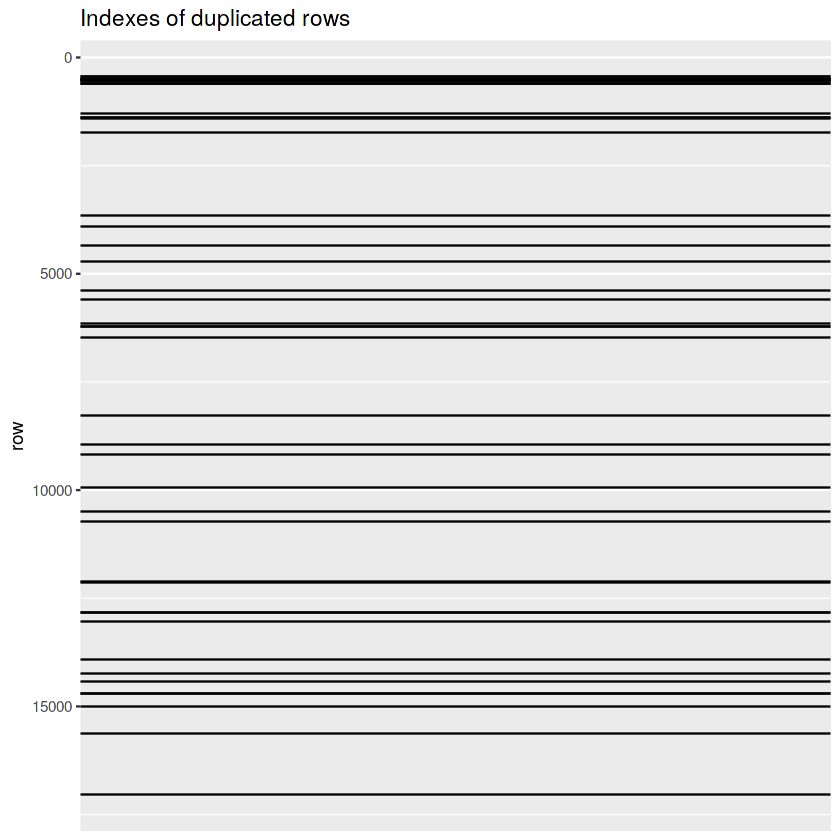

In [12]:
# get the row numbers of duplicated rows
duplicated_rows <- data_frame(duplicated = duplicated(ign_data), row = 1:nrow(ign_data)) %>%
    filter(duplicated == T)

# Plot duplicated rows as black lines
ggplot(duplicated_rows, aes(xintercept = row)) +
    geom_vline(aes(xintercept = row)) + # plot a black line for each duplicated row
    ggtitle("Indexes of duplicated rows") + # add a title
    coord_flip() + scale_x_reverse() #flip x & y axis and reverse the x axis

Looking at this chart tells us two things. First, we do have quite a bit of duplicated data, so we'll probably want to handle that somehow. Secondly, there's no clear pattern to the duplicated values, so it would be too time consuming to remove them by row index.

## Your turn!
___

Plot the indexes of duplicated rows in the `video games` dataset. Are there more or less duplicated rows in this dataset than in the IGN dataset? Do you notice any patterns?

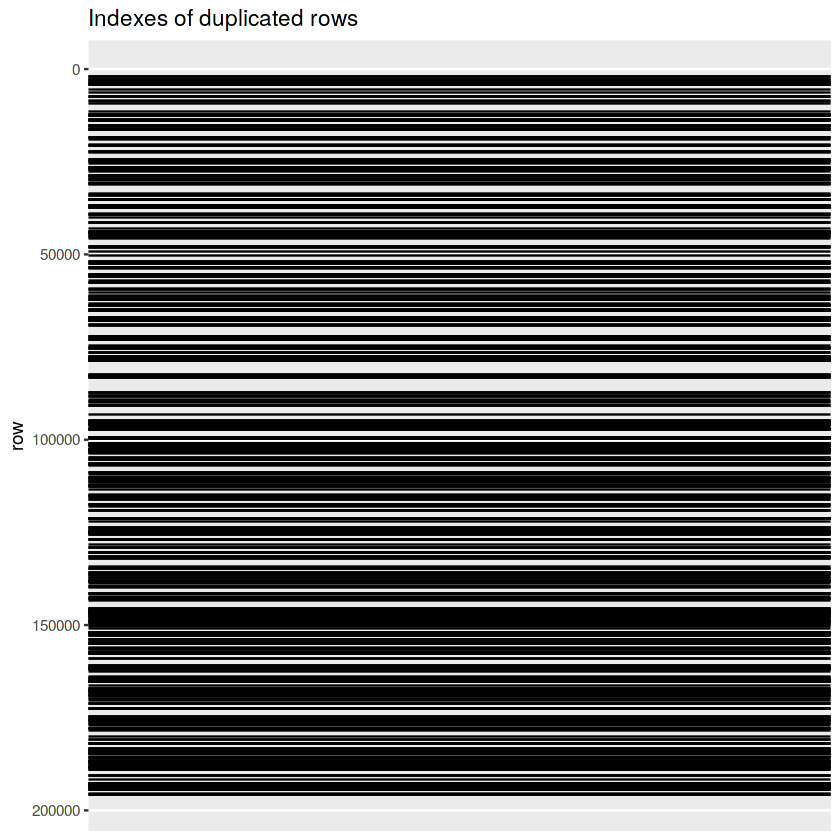

In [13]:
# get the row numbers of duplicated rows
duplicated_rows_1 <- data_frame(duplicated = duplicated(video_games), row = 1:nrow(video_games)) %>%
    filter(duplicated == T)

# Plot duplicated rows as black lines
ggplot(duplicated_rows_1, aes(xintercept = row)) +
    geom_vline(aes(xintercept = row)) + # plot a black line for each duplicated row
    ggtitle("Indexes of duplicated rows") + # add a title
    coord_flip() + scale_x_reverse() #flip x & y axis and reverse the x axis

# Find and remove exact duplicates
____

Now that we know how to find them, let's look at some of our data.

In [4]:
# look at the first few rows
head(ign_data)

While there are some things that I would call "partial duplicates", like the two reviews of "NHL 13" with the same score and release date, I don't see any exact duplicates. We know they exist because we saw them in our visualization earlier, though. Let's use the `duplicated()` function to see how many exactly duplicated rows we have in our dataset:

In [14]:
# count the number of duplicated row in our dataset
duplicated(ign_data) %>%
    sum()

[1] 48

So it looks like there are 48 duplicated rows in our dataset. Fortunately, they are very easy to remove: you can the function `distinct()` to select only the non-duplicated rows in our dataset. Like so:

In [15]:
# get only the distinct rows in our dataset
ign_data_distinct <- distinct(ign_data)

Just to double-check that we did remove all the duplicated rows, let's see how many rows we removed from our dataframe using `distinct()`. 

In [16]:
# how many rows did we remove?
nrow(ign_data) - nrow(ign_data_distinct)

[1] 48

Success! We did remove all 48 rows with exactly duplicates from our dataframe.

## Your turn!
___

Are there any exact duplicates in the `video_games` dataset? If so, try removing them.

In [17]:
duplicated(video_games) %>%
    sum()
video_games_distinct <- distinct(video_games)
duplicated(video_games_distinct) %>%
    sum()

[1] 707

[1] 0

# Find and remove partial duplicates
___

Removing *exact* duplicates is pretty straightforward. Removing partial duplicates, on the other hand, is much more complex. Fortunately, there are some handy tools we can use to make the process easier. I particularly like the [the dedup() function from the scrubr package](https://cran.r-project.org/web/packages/scrubr/vignettes/scrubr_vignette.html) by Scott Chamberlain. (If you haven't run into it before, the scrubr package can help you with a lot of different data cleaning tasks, like removing impossible latitude and longitude coordinates or standardizing dates.)

One of the hassles of removing partial duplicates is that it tends to take a lot of computation time. This is because you need to make a lot of different comparisons to determine which rows only partially match with other ones. It's also because, in this case, we're actually converting every row to a string and then [comparing how similar the strings are](https://www.rdocumentation.org/packages/qlcMatrix/versions/0.9.5/topics/sim.strings) (this can help you catch things like slightly misspelled names). Since it takes longer the larger your dataset is, I'm going to use just the first twenty rows of the IGN dataset for this example so it doesn't take forever. 

In [10]:
# look at just the first 20 rows
ign_data[1:20,]

As you can see, we have a lot of rows that are *almost* the same. Let's see how many of them `dedup()` can catch.

In [18]:
# automatically remove duplicated values, including partials
ign_data_deduped <- ign_data[1:20,] %>%
    dedup()

# see duplicate records
attr(ign_data_deduped, "dups")

score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
Good,Total War Battles: Shogun,/games/total-war-battles-shogun/pc-142564,PC,7.0,Strategy,N,2012,9,11
Okay,Home: A Unique Horror Adventure,/games/home-a-unique-horror-adventure/pc-137135,PC,6.5,Adventure,N,2012,9,6


So we are seeing some partial matches, but not all of them. This is partly because the default tolerance argument for `dedup()` is pretty high (0.9), so it's not picking out all the possible partial matches. Lower tolerance will identify more records are duplicates and higher tolerance will identify fewer.

> [**Tolerance**: Score (0 to 1) at which to determine a match. You’ll want to inspect outputs closely to tweak this value based on your data, as results can vary.](https://cran.r-project.org/web/packages/scrubr/scrubr.pdf)

Let's try again with a lower tolerance and see if we can catch more partial matches:

In [19]:
# automatically remove duplicated values, including partials
ign_data_deduped <- ign_data[1:20,] %>%
    dedup(tolerance = 0.5)

# see duplicate records
attr(ign_data_deduped, "dups")

score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero Edition,/games/littlebigplanet-ps-vita-marvel-super-hero-edition/vita-20027059,PlayStation Vita,9.0,Platformer,Y,2012,9,12
Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11
Good,Tekken Tag Tournament 2,/games/tekken-tag-tournament-2/xbox-360-124581,Xbox 360,7.5,Fighting,N,2012,9,11
Good,Total War Battles: Shogun,/games/total-war-battles-shogun/pc-142564,PC,7.0,Strategy,N,2012,9,11
Awful,Double Dragon: Neon,/games/double-dragon-neon/ps3-131321,PlayStation 3,3.0,Fighting,N,2012,9,11
Good,Tekken Tag Tournament 2,/games/tekken-tag-tournament-2/xbox-360-124581,Xbox 360,7.5,Fighting,N,2012,9,11
Good,JoJo's Bizarre Adventure HD,/games/jojos-bizarre-adventure/xbox-360-137717,Xbox 360,7.0,Fighting,N,2012,9,3
Amazing,Mark of the Ninja,/games/mark-of-the-ninja-135615/pc-143761,PC,9.0,"Action, Adventure",Y,2012,9,7
Good,JoJo's Bizarre Adventure HD,/games/jojos-bizarre-adventure/xbox-360-137717,Xbox 360,7.0,Fighting,N,2012,9,3
Okay,Home: A Unique Horror Adventure,/games/home-a-unique-horror-adventure/pc-137135,PC,6.5,Adventure,N,2012,9,6


That looks much better to me! From here on, I can just use the `ign_data_deduped` dataframe when working with my data. 

## Your turn!
___

Are there any exact duplicates in the `video_games` dataset? If so, try removing them.

Then try removing partial duplicates using `dedup()`.  Try adjusting the tolerance. If you're feeling very ambitious, try recording & graphing how different tolerance values map to the number of duplicates detected and removed.

In [22]:
# automatically remove duplicated values, including partials
video_games_deduped <- video_games[1:20,] %>%
    dedup(tolerance = 0.7)

# see duplicate records
attr(video_games_deduped, "dups")

user_id,game_title,behavior_name,value
151603712,The Elder Scrolls V Skyrim,play,273.0
151603712,Fallout 4,play,87.0
151603712,Spore,purchase,1.0
151603712,Fallout New Vegas,purchase,1.0
151603712,Left 4 Dead 2,purchase,1.0
151603712,HuniePop,purchase,1.0
151603712,Poly Bridge,purchase,1.0
151603712,Left 4 Dead,purchase,1.0
151603712,Fallout New Vegas,purchase,1.0
151603712,Left 4 Dead 2,purchase,1.0


# And that's it for Day 4!
___

And that's it for today! If you have any questions, be sure to post them in the comments below or on the forums.

Remember that your notebook is private by default, and in order to share it with other people or ask for help with it, you'll need to make it public. First, you'll need to save a version of your notebook that shows your current work by hitting the "Commit & Run" button. (Your work is saved automatically, but versioning your work lets you go back and look at what it was like at the point you saved it. It also lets you share a nice compiled notebook instead of just the raw code.) Then, once your notebook is finished running, you can go to the Settings tab in the panel to the left (you may have to expand it by hitting the [<] button next to the "Commit & Run" button) and setting the "Visibility" dropdown to "Public". 

